## single step
- https://github.com/oliverguhr/transformer-time-series-prediction/blob/master/transformer-singlestep.py

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.11.06</div>
<div style="text-align: right"> Last update: 2023.11.06</div>

In [1]:
import datetime
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

In [2]:
import torch
import torch.nn as nn
import time
import math
from sklearn.preprocessing import MinMaxScaler

In [3]:
data = pd.read_csv("daily-min-temperature.csv")
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
data.shape

(3650, 2)

In [5]:
# S is 소스 시퀀스 길이
# T is 타겟 시퀀스 길이
# N is 배치 사이즈
# E is 피처수

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)

In [6]:
input_window = 100 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pair
batch_size = 10
train_size = 0.8

In [7]:
device = 'mps'

### 1. 포지션 인코딩

하나씩 실행해보기

In [8]:
d_model = 10
max_len = 5000

In [9]:
pe = torch.zeros(max_len, d_model)
pe.shape

torch.Size([5000, 10])

In [10]:
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
position.shape

torch.Size([5000, 1])

In [11]:
position

tensor([[0.0000e+00],
        [1.0000e+00],
        [2.0000e+00],
        ...,
        [4.9970e+03],
        [4.9980e+03],
        [4.9990e+03]])

In [12]:
div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
div_term.shape

(10,)

In [13]:
div_term

array([1.00000000e+00, 1.58489319e-01, 2.51188643e-02, 3.98107171e-03,
       6.30957344e-04, 1.00000000e-04, 1.58489319e-05, 2.51188643e-06,
       3.98107171e-07, 6.30957344e-08])

In [14]:
div_term[0::2]

array([1.00000000e+00, 2.51188643e-02, 6.30957344e-04, 1.58489319e-05,
       3.98107171e-07])

In [15]:
div_term[1::2]

array([1.58489319e-01, 3.98107171e-03, 1.00000000e-04, 2.51188643e-06,
       6.30957344e-08])

In [16]:
pe[:, 0::2] = torch.sin(position * div_term[0::2])
pe[:, 1::2] = torch.cos(position * div_term[1::2])

In [17]:
pe.shape

torch.Size([5000, 10])

In [18]:
pe.unsqueeze(0).shape

torch.Size([1, 5000, 10])

In [19]:
pe = pe.unsqueeze(0).transpose(0, 1) # batch last로 구현함
pe.shape

torch.Size([5000, 1, 10])

- batch last

In [20]:
batch_size = 32
seq_len = 50
embedding_dim = 10

# 임의의 수로 채워진 텐서를 생성합니다.
dummy_input = torch.randn(seq_len, batch_size, embedding_dim)

In [21]:
dummy_input.shape

torch.Size([50, 32, 10])

In [22]:
pe[:dummy_input.size(0), :].shape

torch.Size([50, 1, 10])

In [23]:
pe[:dummy_input.size(0), :].repeat(1, dummy_input.shape[1], 1).shape

torch.Size([50, 32, 10])

클래스로 구현하기: batch first가 아님

In [24]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

In [25]:
pe = PositionalEncoding(
    d_model=10
)

In [26]:
dummy_input.shape

torch.Size([50, 32, 10])

In [27]:
pe(dummy_input).shape

torch.Size([50, 32, 10])

### 2. Model

In [28]:
class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(1,feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
        
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]

- 실제로 샘플의 수를 N이라고 가정하면,   
- 입력 시퀀스의 길이는 m이고 역방향 예측은 k 스텝이다,??? 
- 그렇다면 블록의 길이 [입력 : 1 , 2 ... m -> 출력 : k , k+1....m+k ]는 (m+k) 이어야 한다.
- 따라서 block_len이 완전한지 확인하기 위하여... 
- 마지막 블록의 끝 요소는 전체 시퀀스의 끝 요소여야 한다. 
- 따라서 실제 블록 수는 [N - block_len + 1]입니다. 

### 입력 데이터 만들기 함수

In [29]:
def create_inout_sequences(
    input_data,
    input_window,
    output_window,
    block_len
):
    inout_seq = []
    L = len(input_data)
    block_num = L - block_len + 1
    
    for i in range(block_num):
        train_seq = input_data[i: i + input_window]
        train_label = input_data[i+output_window: i + input_window + output_window] # 확인요
        inout_seq.append((train_seq, train_label))
        
    return torch.FloatTensor(np.array(inout_seq))

In [30]:
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [31]:
input_window = 100 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pair

In [32]:
inout_seq = create_inout_sequences(
    data['Temp'].values,
    input_window=input_window,
    output_window=output_window,
    block_len=block_len
)

In [33]:
inout_seq

tensor([[[20.7000, 17.9000, 18.8000,  ..., 14.9000, 15.9000, 13.0000],
         [17.9000, 18.8000, 14.6000,  ..., 15.9000, 13.0000,  7.6000]],

        [[17.9000, 18.8000, 14.6000,  ..., 15.9000, 13.0000,  7.6000],
         [18.8000, 14.6000, 15.8000,  ..., 13.0000,  7.6000, 11.5000]],

        [[18.8000, 14.6000, 15.8000,  ..., 13.0000,  7.6000, 11.5000],
         [14.6000, 15.8000, 15.8000,  ...,  7.6000, 11.5000, 13.5000]],

        ...,

        [[16.3000,  9.6000,  6.8000,  ..., 14.6000, 14.0000, 13.6000],
         [ 9.6000,  6.8000,  5.2000,  ..., 14.0000, 13.6000, 13.5000]],

        [[ 9.6000,  6.8000,  5.2000,  ..., 14.0000, 13.6000, 13.5000],
         [ 6.8000,  5.2000, 10.6000,  ..., 13.6000, 13.5000, 15.7000]],

        [[ 6.8000,  5.2000, 10.6000,  ..., 13.6000, 13.5000, 15.7000],
         [ 5.2000, 10.6000, 16.3000,  ..., 13.5000, 15.7000, 13.0000]]])

In [34]:
inout_seq[0][0].shape

torch.Size([100])

In [35]:
inout_seq[0][1].shape

torch.Size([100])

In [36]:
inout_seq[0][0]

tensor([20.7000, 17.9000, 18.8000, 14.6000, 15.8000, 15.8000, 15.8000, 17.4000,
        21.8000, 20.0000, 16.2000, 13.3000, 16.7000, 21.5000, 25.0000, 20.7000,
        20.6000, 24.8000, 17.7000, 15.5000, 18.2000, 12.1000, 14.4000, 16.0000,
        16.5000, 18.7000, 19.4000, 17.2000, 15.5000, 15.1000, 15.4000, 15.3000,
        18.8000, 21.9000, 19.9000, 16.6000, 16.8000, 14.6000, 17.1000, 25.0000,
        15.0000, 13.7000, 13.9000, 18.3000, 22.0000, 22.1000, 21.2000, 18.4000,
        16.6000, 16.1000, 15.7000, 16.6000, 16.5000, 14.4000, 14.4000, 18.5000,
        16.9000, 17.5000, 21.2000, 17.8000, 18.6000, 17.0000, 16.0000, 13.3000,
        14.3000, 11.4000, 16.3000, 16.1000, 11.8000, 12.2000, 14.7000, 11.8000,
        11.3000, 10.6000, 11.7000, 14.2000, 11.2000, 16.9000, 16.7000,  8.1000,
         8.0000,  8.8000, 13.4000, 10.9000, 13.4000, 11.0000, 15.0000, 15.7000,
        14.5000, 15.8000, 16.7000, 16.8000, 17.5000, 17.1000, 18.1000, 16.6000,
        10.0000, 14.9000, 15.9000, 13.00

In [37]:
inout_seq[0][1]

tensor([17.9000, 18.8000, 14.6000, 15.8000, 15.8000, 15.8000, 17.4000, 21.8000,
        20.0000, 16.2000, 13.3000, 16.7000, 21.5000, 25.0000, 20.7000, 20.6000,
        24.8000, 17.7000, 15.5000, 18.2000, 12.1000, 14.4000, 16.0000, 16.5000,
        18.7000, 19.4000, 17.2000, 15.5000, 15.1000, 15.4000, 15.3000, 18.8000,
        21.9000, 19.9000, 16.6000, 16.8000, 14.6000, 17.1000, 25.0000, 15.0000,
        13.7000, 13.9000, 18.3000, 22.0000, 22.1000, 21.2000, 18.4000, 16.6000,
        16.1000, 15.7000, 16.6000, 16.5000, 14.4000, 14.4000, 18.5000, 16.9000,
        17.5000, 21.2000, 17.8000, 18.6000, 17.0000, 16.0000, 13.3000, 14.3000,
        11.4000, 16.3000, 16.1000, 11.8000, 12.2000, 14.7000, 11.8000, 11.3000,
        10.6000, 11.7000, 14.2000, 11.2000, 16.9000, 16.7000,  8.1000,  8.0000,
         8.8000, 13.4000, 10.9000, 13.4000, 11.0000, 15.0000, 15.7000, 14.5000,
        15.8000, 16.7000, 16.8000, 17.5000, 17.1000, 18.1000, 16.6000, 10.0000,
        14.9000, 15.9000, 13.0000,  7.60

In [38]:
def get_data(
    block_len,      
    train_size=0.8,   
             ):
    # construct a littel toy dataset
    time        = np.arange(0, 400, 0.1)    
    amplitude   = np.sin(time) + np.sin(time * 0.05) + \
                  np.sin(time * 0.12) * np.random.normal(-0.2, 0.2, len(time))
    
    #loading weather data from a file
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    
    # looks like normalizing input values curtial for the model
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    sampels = int(len(time) * train_size) # use a parameter to control training size
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)

    train_sequence = create_inout_sequences( train_data,input_window ,output_window, block_len=block_len)
    '''
    train_sequence = train_sequence[:-output_window] # todo: fix hack? -> din't think this through, looks like the last n sequences are to short, so I just remove them. Hackety Hack..
    # looks like maybe solved
    '''
    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window,output_window, block_len=block_len)
    '''
    test_data = test_data[:-output_window] # todo: fix hack?
    '''
    # shape with (block , sql_len , 2 )
    return train_sequence.to(device),test_data.to(device)

In [39]:
train_test, test_test = get_data(block_len=block_len)

In [40]:

len(train_test)

3100

In [41]:
len(test_test)

700

배치로 구현? : 확인요

In [42]:
def get_batch(input_data, i , batch_size):

    # batch_len = min(batch_size, len(input_data) - 1 - i) #  # Now len-1 is not necessary
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[ i:i + batch_len ]
    input = torch.stack([item[0] for item in data]).view((input_window,batch_len,1))
    # ( seq_len, batch, 1 ) , 1 is feature size
    target = torch.stack([item[1] for item in data]).view((input_window,batch_len,1))
    return input, target

### 3. 학습루프, 시각화, 평가

In [43]:
def train(train_data,
          model,
          optimizer,
          criterion,
          epoch,
          scheduler,
          batch_size = 10
          ):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data), batch_size)):  # Now len-1 is not necessary
        # data and target are the same shape with (input_window,batch_len,1)
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [44]:
def plot_and_loss(eval_model, data_source, criterion, epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1):
        for i in range(len(data_source)):  # Now len-1 is not necessary
            data, target = get_batch(data_source, i , 1) # one-step forecast
            output = eval_model(data)            
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy() -> no need to detach stuff.. 
    len(test_result)

    plt.plot(test_result,color="red")
    plt.plot(truth[:500],color="blue")
    plt.plot(test_result-truth,color="green")
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.savefig('graph/transformer-epoch%d.png'%epoch)
    plt.close()
    return total_loss / i

In [45]:
def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source , 0 , 1)
    with torch.no_grad():
        for i in range(0, steps):            
            output = eval_model(data[-input_window:])
            # (seq-len , batch-size , features-num)
            # input : [ m,m+1,...,m+n ] -> [m+1,...,m+n+1]
            data = torch.cat((data, output[-1:])) # [m,m+1,..., m+n+1]

    data = data.cpu().view(-1)
    
    # I used this plot to visualize if the model pics up any long therm structure within the data.
    plt.plot(data,color="red")       
    plt.plot(data[:input_window],color="blue")    
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.savefig('graph/transformer-future%d.png'%steps)
    plt.show()
    plt.close()

In [46]:
def evaluate(
    eval_model, 
    data_source,
    criterion    
    ):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1, eval_batch_size): # Now len-1 is not necessary
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

### 4. 모델 학습해보기

In [47]:
input_window = 100 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pair
batch_size = 10
train_size = 0.8

criterion = nn.MSELoss()
lr = 0.005 

In [48]:
model = TransAm().to(device)

In [49]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

In [50]:
best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

In [51]:
train_data, val_data = get_data(
    block_len=block_len,
    train_size=0.8
)

| epoch   1 |    62/  310 batches | lr 0.005000 | 26.12 ms | loss 5.45075 | ppl   232.93


| epoch   1 |   124/  310 batches | lr 0.005000 | 18.39 ms | loss 0.09715 | ppl     1.10
| epoch   1 |   186/  310 batches | lr 0.005000 | 17.81 ms | loss 0.02580 | ppl     1.03
| epoch   1 |   248/  310 batches | lr 0.005000 | 17.88 ms | loss 0.01895 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  6.31s | valid loss 0.05174 | valid ppl     1.05
-----------------------------------------------------------------------------------------
| epoch   2 |    62/  310 batches | lr 0.004513 | 17.40 ms | loss 0.02085 | ppl     1.02
| epoch   2 |   124/  310 batches | lr 0.004513 | 17.69 ms | loss 0.01283 | ppl     1.01
| epoch   2 |   186/  310 batches | lr 0.004513 | 17.14 ms | loss 0.01339 | ppl     1.01
| epoch   2 |   248/  310 batches | lr 0.004513 | 17.13 ms | loss 0.01707 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  5.5

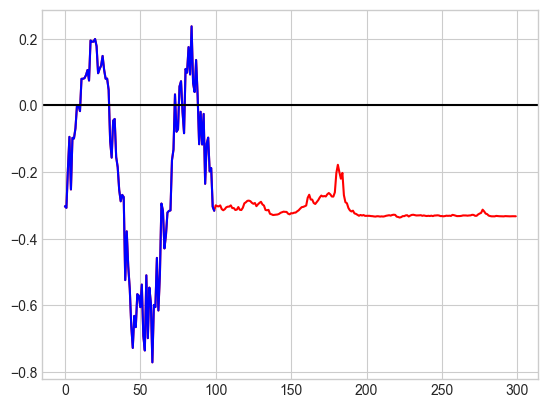

-----------------------------------------------------------------------------------------
| end of epoch   5 | time:  9.12s | valid loss 0.03831 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch   6 |    62/  310 batches | lr 0.003675 | 18.47 ms | loss 0.01052 | ppl     1.01
| epoch   6 |   124/  310 batches | lr 0.003675 | 17.50 ms | loss 0.01215 | ppl     1.01
| epoch   6 |   186/  310 batches | lr 0.003675 | 16.69 ms | loss 0.01204 | ppl     1.01
| epoch   6 |   248/  310 batches | lr 0.003675 | 17.42 ms | loss 0.01115 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch   6 | time:  5.53s | valid loss 0.04450 | valid ppl     1.05
-----------------------------------------------------------------------------------------
| epoch   7 |    62/  310 batches | lr 0.003492 | 17.03 ms | loss 0.01112 | ppl     1.01
| epoch   7 |   124/  310 batches | lr 0.00

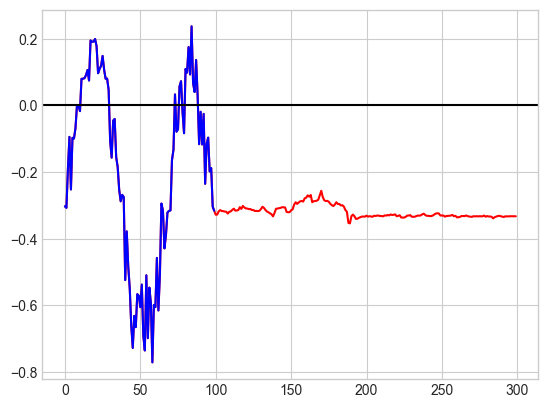

-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  8.49s | valid loss 0.03441 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch  11 |    62/  310 batches | lr 0.002844 | 17.62 ms | loss 0.00988 | ppl     1.01
| epoch  11 |   124/  310 batches | lr 0.002844 | 17.19 ms | loss 0.00982 | ppl     1.01
| epoch  11 |   186/  310 batches | lr 0.002844 | 17.64 ms | loss 0.01028 | ppl     1.01
| epoch  11 |   248/  310 batches | lr 0.002844 | 17.38 ms | loss 0.01034 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  11 | time:  5.58s | valid loss 0.03219 | valid ppl     1.03
-----------------------------------------------------------------------------------------
| epoch  12 |    62/  310 batches | lr 0.002702 | 17.70 ms | loss 0.00964 | ppl     1.01
| epoch  12 |   124/  310 batches | lr 0.00

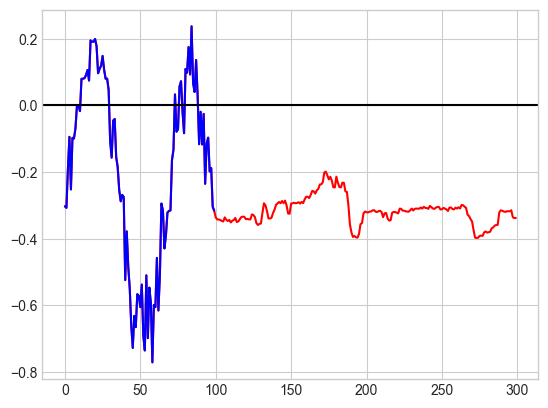

-----------------------------------------------------------------------------------------
| end of epoch  15 | time:  8.59s | valid loss 0.03260 | valid ppl     1.03
-----------------------------------------------------------------------------------------
| epoch  16 |    62/  310 batches | lr 0.002201 | 17.84 ms | loss 0.00938 | ppl     1.01
| epoch  16 |   124/  310 batches | lr 0.002201 | 17.68 ms | loss 0.00995 | ppl     1.01
| epoch  16 |   186/  310 batches | lr 0.002201 | 17.90 ms | loss 0.00970 | ppl     1.01
| epoch  16 |   248/  310 batches | lr 0.002201 | 17.36 ms | loss 0.01036 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  16 | time:  5.62s | valid loss 0.03494 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch  17 |    62/  310 batches | lr 0.002091 | 17.65 ms | loss 0.00951 | ppl     1.01
| epoch  17 |   124/  310 batches | lr 0.00

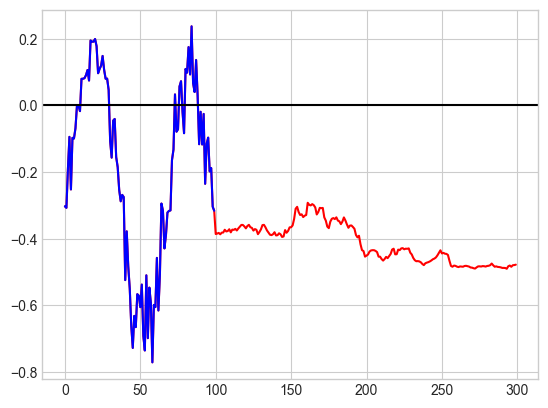

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  8.12s | valid loss 0.02929 | valid ppl     1.03
-----------------------------------------------------------------------------------------
| epoch  21 |    62/  310 batches | lr 0.001703 | 16.93 ms | loss 0.00906 | ppl     1.01
| epoch  21 |   124/  310 batches | lr 0.001703 | 17.70 ms | loss 0.00924 | ppl     1.01
| epoch  21 |   186/  310 batches | lr 0.001703 | 17.76 ms | loss 0.00909 | ppl     1.01
| epoch  21 |   248/  310 batches | lr 0.001703 | 16.29 ms | loss 0.01016 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  21 | time:  5.43s | valid loss 0.02430 | valid ppl     1.02
-----------------------------------------------------------------------------------------
| epoch  22 |    62/  310 batches | lr 0.001618 | 16.67 ms | loss 0.00906 | ppl     1.01
| epoch  22 |   124/  310 batches | lr 0.00

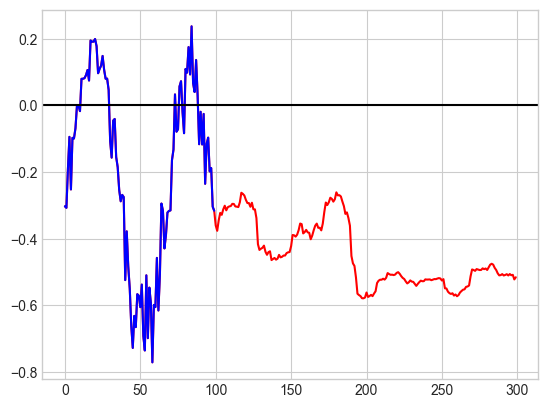

-----------------------------------------------------------------------------------------
| end of epoch  25 | time:  8.03s | valid loss 0.02472 | valid ppl     1.03
-----------------------------------------------------------------------------------------
| epoch  26 |    62/  310 batches | lr 0.001318 | 18.23 ms | loss 0.00906 | ppl     1.01
| epoch  26 |   124/  310 batches | lr 0.001318 | 17.66 ms | loss 0.00912 | ppl     1.01
| epoch  26 |   186/  310 batches | lr 0.001318 | 17.41 ms | loss 0.00876 | ppl     1.01
| epoch  26 |   248/  310 batches | lr 0.001318 | 17.66 ms | loss 0.01044 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  26 | time:  5.65s | valid loss 0.01982 | valid ppl     1.02
-----------------------------------------------------------------------------------------
| epoch  27 |    62/  310 batches | lr 0.001252 | 17.86 ms | loss 0.00889 | ppl     1.01
| epoch  27 |   124/  310 batches | lr 0.00

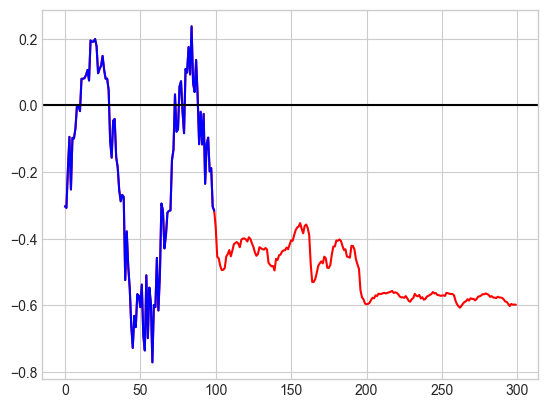

-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  8.07s | valid loss 0.01955 | valid ppl     1.02
-----------------------------------------------------------------------------------------
| epoch  31 |    62/  310 batches | lr 0.001020 | 17.72 ms | loss 0.00878 | ppl     1.01
| epoch  31 |   124/  310 batches | lr 0.001020 | 17.29 ms | loss 0.00882 | ppl     1.01
| epoch  31 |   186/  310 batches | lr 0.001020 | 16.78 ms | loss 0.00839 | ppl     1.01
| epoch  31 |   248/  310 batches | lr 0.001020 | 16.14 ms | loss 0.01016 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  31 | time:  5.40s | valid loss 0.01482 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  32 |    62/  310 batches | lr 0.000969 | 16.95 ms | loss 0.00878 | ppl     1.01
| epoch  32 |   124/  310 batches | lr 0.00

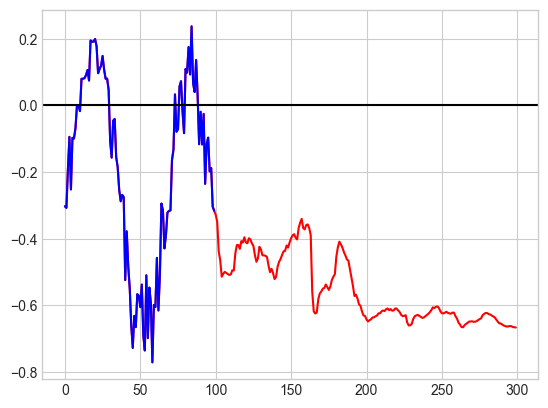

-----------------------------------------------------------------------------------------
| end of epoch  35 | time:  8.65s | valid loss 0.01579 | valid ppl     1.02
-----------------------------------------------------------------------------------------
| epoch  36 |    62/  310 batches | lr 0.000789 | 18.26 ms | loss 0.00865 | ppl     1.01
| epoch  36 |   124/  310 batches | lr 0.000789 | 16.85 ms | loss 0.00859 | ppl     1.01
| epoch  36 |   186/  310 batches | lr 0.000789 | 16.53 ms | loss 0.00829 | ppl     1.01
| epoch  36 |   248/  310 batches | lr 0.000789 | 17.11 ms | loss 0.00996 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  36 | time:  5.51s | valid loss 0.01137 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  37 |    62/  310 batches | lr 0.000749 | 17.66 ms | loss 0.00852 | ppl     1.01
| epoch  37 |   124/  310 batches | lr 0.00

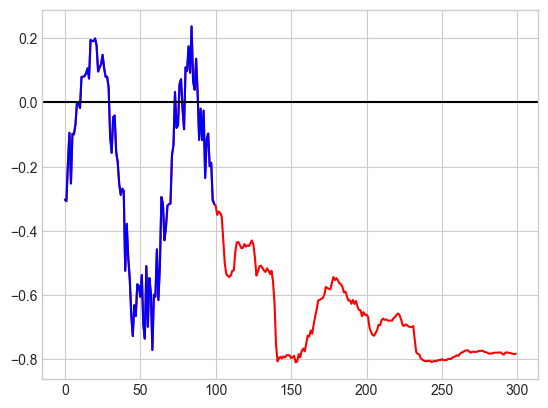

-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  8.37s | valid loss 0.01318 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  41 |    62/  310 batches | lr 0.000610 | 17.46 ms | loss 0.00825 | ppl     1.01
| epoch  41 |   124/  310 batches | lr 0.000610 | 16.88 ms | loss 0.00852 | ppl     1.01
| epoch  41 |   186/  310 batches | lr 0.000610 | 16.88 ms | loss 0.00808 | ppl     1.01
| epoch  41 |   248/  310 batches | lr 0.000610 | 17.45 ms | loss 0.00942 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  41 | time:  5.57s | valid loss 0.01061 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  42 |    62/  310 batches | lr 0.000580 | 18.83 ms | loss 0.00823 | ppl     1.01
| epoch  42 |   124/  310 batches | lr 0.00

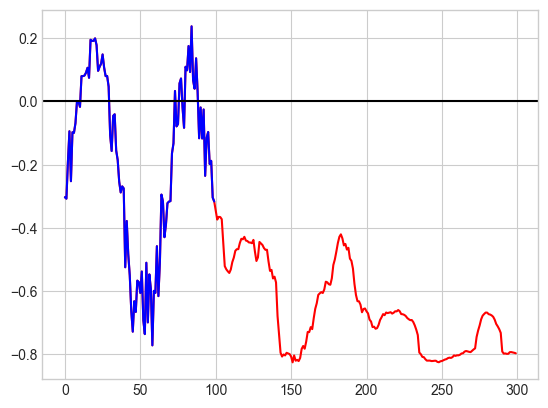

-----------------------------------------------------------------------------------------
| end of epoch  45 | time:  8.35s | valid loss 0.01208 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  46 |    62/  310 batches | lr 0.000472 | 18.35 ms | loss 0.00801 | ppl     1.01
| epoch  46 |   124/  310 batches | lr 0.000472 | 17.43 ms | loss 0.00843 | ppl     1.01
| epoch  46 |   186/  310 batches | lr 0.000472 | 17.01 ms | loss 0.00797 | ppl     1.01
| epoch  46 |   248/  310 batches | lr 0.000472 | 17.01 ms | loss 0.00919 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  46 | time:  5.61s | valid loss 0.00970 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  47 |    62/  310 batches | lr 0.000449 | 17.14 ms | loss 0.00797 | ppl     1.01
| epoch  47 |   124/  310 batches | lr 0.00

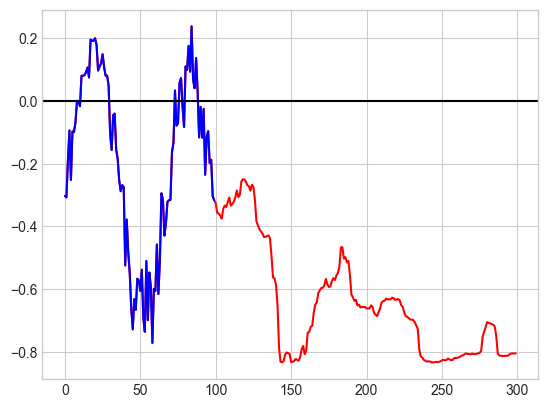

-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  8.27s | valid loss 0.01191 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  51 |    62/  310 batches | lr 0.000365 | 16.78 ms | loss 0.00779 | ppl     1.01
| epoch  51 |   124/  310 batches | lr 0.000365 | 16.22 ms | loss 0.00839 | ppl     1.01
| epoch  51 |   186/  310 batches | lr 0.000365 | 16.33 ms | loss 0.00787 | ppl     1.01
| epoch  51 |   248/  310 batches | lr 0.000365 | 16.05 ms | loss 0.00894 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  51 | time:  5.22s | valid loss 0.00960 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  52 |    62/  310 batches | lr 0.000347 | 17.69 ms | loss 0.00775 | ppl     1.01
| epoch  52 |   124/  310 batches | lr 0.00

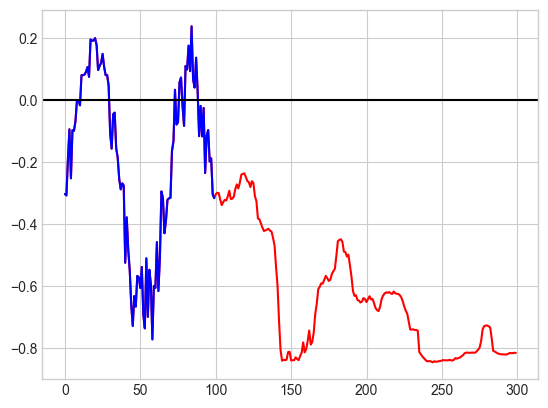

-----------------------------------------------------------------------------------------
| end of epoch  55 | time:  8.08s | valid loss 0.01207 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  56 |    62/  310 batches | lr 0.000283 | 17.00 ms | loss 0.00765 | ppl     1.01
| epoch  56 |   124/  310 batches | lr 0.000283 | 16.33 ms | loss 0.00828 | ppl     1.01
| epoch  56 |   186/  310 batches | lr 0.000283 | 16.29 ms | loss 0.00778 | ppl     1.01
| epoch  56 |   248/  310 batches | lr 0.000283 | 16.28 ms | loss 0.00874 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  56 | time:  5.27s | valid loss 0.00959 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  57 |    62/  310 batches | lr 0.000269 | 17.00 ms | loss 0.00760 | ppl     1.01
| epoch  57 |   124/  310 batches | lr 0.00

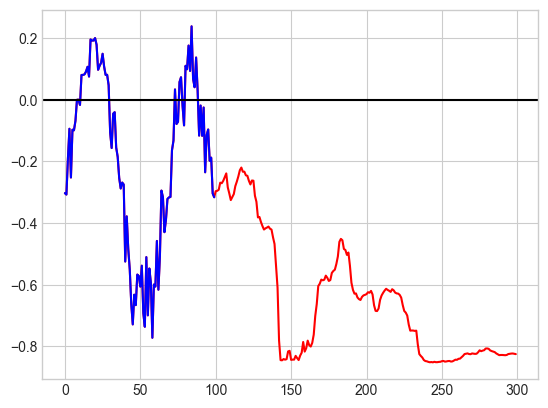

-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  8.67s | valid loss 0.01227 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  61 |    62/  310 batches | lr 0.000219 | 18.27 ms | loss 0.00753 | ppl     1.01
| epoch  61 |   124/  310 batches | lr 0.000219 | 17.75 ms | loss 0.00825 | ppl     1.01
| epoch  61 |   186/  310 batches | lr 0.000219 | 17.82 ms | loss 0.00762 | ppl     1.01
| epoch  61 |   248/  310 batches | lr 0.000219 | 17.46 ms | loss 0.00861 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  61 | time:  5.73s | valid loss 0.00953 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  62 |    62/  310 batches | lr 0.000208 | 18.04 ms | loss 0.00751 | ppl     1.01
| epoch  62 |   124/  310 batches | lr 0.00

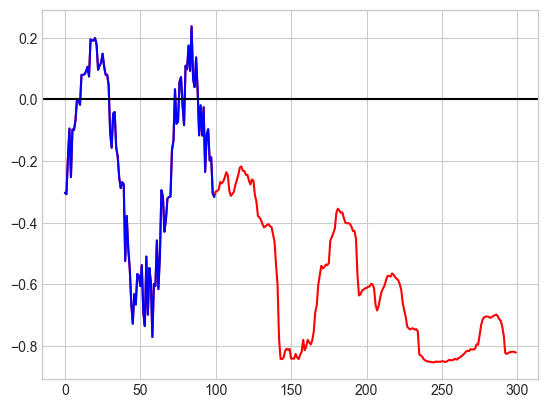

-----------------------------------------------------------------------------------------
| end of epoch  65 | time:  8.57s | valid loss 0.01220 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  66 |    62/  310 batches | lr 0.000169 | 17.95 ms | loss 0.00745 | ppl     1.01
| epoch  66 |   124/  310 batches | lr 0.000169 | 17.45 ms | loss 0.00816 | ppl     1.01
| epoch  66 |   186/  310 batches | lr 0.000169 | 17.45 ms | loss 0.00756 | ppl     1.01
| epoch  66 |   248/  310 batches | lr 0.000169 | 17.52 ms | loss 0.00849 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  66 | time:  5.62s | valid loss 0.00938 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  67 |    62/  310 batches | lr 0.000161 | 18.07 ms | loss 0.00737 | ppl     1.01
| epoch  67 |   124/  310 batches | lr 0.00

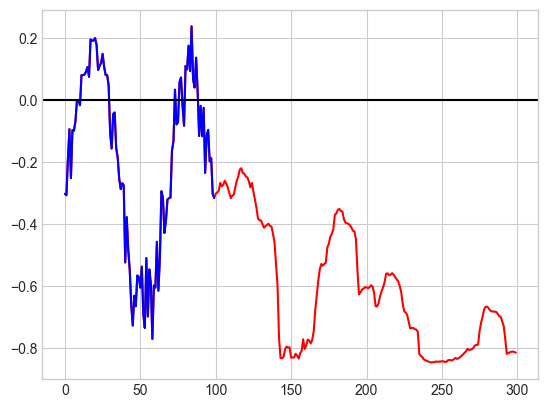

-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  8.72s | valid loss 0.01219 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  71 |    62/  310 batches | lr 0.000131 | 18.20 ms | loss 0.00734 | ppl     1.01
| epoch  71 |   124/  310 batches | lr 0.000131 | 17.62 ms | loss 0.00809 | ppl     1.01
| epoch  71 |   186/  310 batches | lr 0.000131 | 18.32 ms | loss 0.00744 | ppl     1.01
| epoch  71 |   248/  310 batches | lr 0.000131 | 17.47 ms | loss 0.00833 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  71 | time:  5.72s | valid loss 0.00926 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  72 |    62/  310 batches | lr 0.000124 | 17.89 ms | loss 0.00733 | ppl     1.01
| epoch  72 |   124/  310 batches | lr 0.00

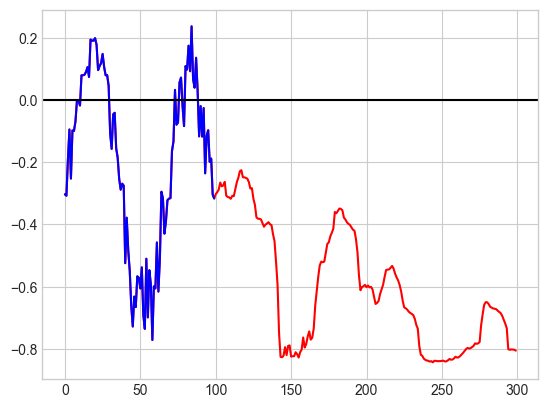

-----------------------------------------------------------------------------------------
| end of epoch  75 | time:  8.53s | valid loss 0.01220 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  76 |    62/  310 batches | lr 0.000101 | 18.12 ms | loss 0.00730 | ppl     1.01
| epoch  76 |   124/  310 batches | lr 0.000101 | 17.47 ms | loss 0.00805 | ppl     1.01
| epoch  76 |   186/  310 batches | lr 0.000101 | 17.22 ms | loss 0.00736 | ppl     1.01
| epoch  76 |   248/  310 batches | lr 0.000101 | 16.95 ms | loss 0.00826 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  76 | time:  5.57s | valid loss 0.00898 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  77 |    62/  310 batches | lr 0.000096 | 18.32 ms | loss 0.00729 | ppl     1.01
| epoch  77 |   124/  310 batches | lr 0.00

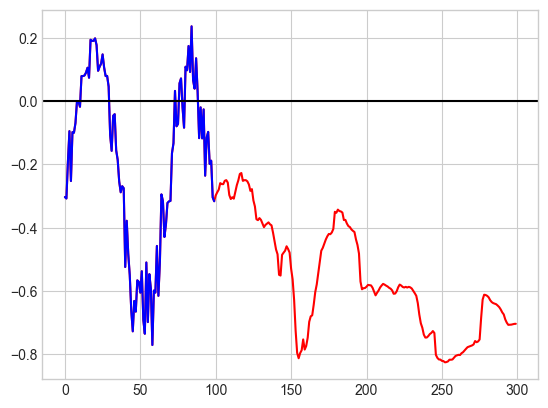

-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  8.70s | valid loss 0.01215 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  81 |    62/  310 batches | lr 0.000078 | 18.49 ms | loss 0.00726 | ppl     1.01
| epoch  81 |   124/  310 batches | lr 0.000078 | 17.73 ms | loss 0.00795 | ppl     1.01
| epoch  81 |   186/  310 batches | lr 0.000078 | 17.56 ms | loss 0.00734 | ppl     1.01
| epoch  81 |   248/  310 batches | lr 0.000078 | 17.34 ms | loss 0.00819 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  81 | time:  5.68s | valid loss 0.00871 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  82 |    62/  310 batches | lr 0.000075 | 18.10 ms | loss 0.00730 | ppl     1.01
| epoch  82 |   124/  310 batches | lr 0.00

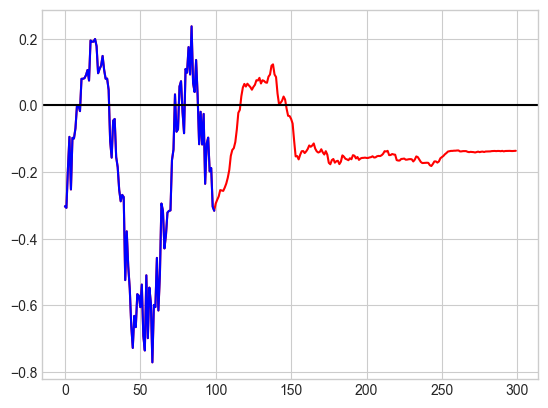

-----------------------------------------------------------------------------------------
| end of epoch  85 | time:  8.59s | valid loss 0.01225 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  86 |    62/  310 batches | lr 0.000061 | 17.76 ms | loss 0.00729 | ppl     1.01
| epoch  86 |   124/  310 batches | lr 0.000061 | 17.23 ms | loss 0.00784 | ppl     1.01
| epoch  86 |   186/  310 batches | lr 0.000061 | 17.54 ms | loss 0.00735 | ppl     1.01
| epoch  86 |   248/  310 batches | lr 0.000061 | 17.33 ms | loss 0.00808 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  86 | time:  5.61s | valid loss 0.00858 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  87 |    62/  310 batches | lr 0.000058 | 18.48 ms | loss 0.00727 | ppl     1.01
| epoch  87 |   124/  310 batches | lr 0.00

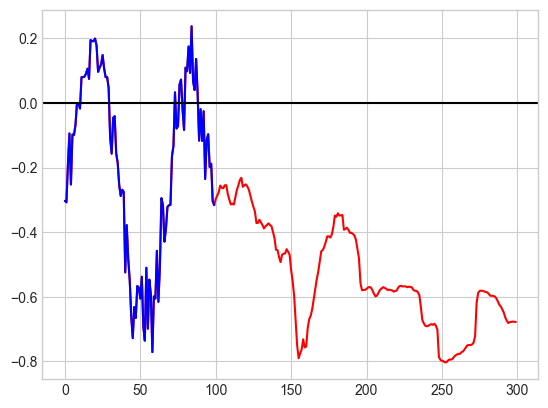

-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  8.65s | valid loss 0.01222 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  91 |    62/  310 batches | lr 0.000047 | 18.13 ms | loss 0.00722 | ppl     1.01
| epoch  91 |   124/  310 batches | lr 0.000047 | 17.27 ms | loss 0.00778 | ppl     1.01
| epoch  91 |   186/  310 batches | lr 0.000047 | 17.54 ms | loss 0.00733 | ppl     1.01
| epoch  91 |   248/  310 batches | lr 0.000047 | 17.54 ms | loss 0.00808 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  91 | time:  5.65s | valid loss 0.00853 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  92 |    62/  310 batches | lr 0.000045 | 18.91 ms | loss 0.00724 | ppl     1.01
| epoch  92 |   124/  310 batches | lr 0.00

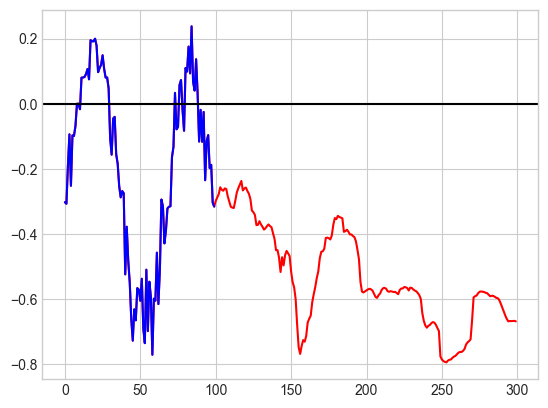

-----------------------------------------------------------------------------------------
| end of epoch  95 | time:  8.77s | valid loss 0.01223 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  96 |    62/  310 batches | lr 0.000036 | 18.20 ms | loss 0.00723 | ppl     1.01
| epoch  96 |   124/  310 batches | lr 0.000036 | 17.61 ms | loss 0.00774 | ppl     1.01
| epoch  96 |   186/  310 batches | lr 0.000036 | 17.48 ms | loss 0.00727 | ppl     1.01
| epoch  96 |   248/  310 batches | lr 0.000036 | 17.81 ms | loss 0.00805 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  96 | time:  5.67s | valid loss 0.00851 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  97 |    62/  310 batches | lr 0.000035 | 18.40 ms | loss 0.00720 | ppl     1.01
| epoch  97 |   124/  310 batches | lr 0.00

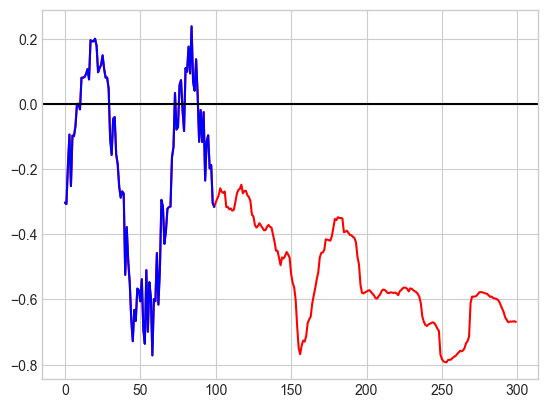

-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  8.76s | valid loss 0.01218 | valid ppl     1.01
-----------------------------------------------------------------------------------------


In [52]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(
        train_data=train_data,
        model = model,
        optimizer=optimizer,
        criterion=criterion,
        epoch=epoch,
        scheduler=scheduler
    )
    
    if ( epoch % 5 == 0 ):
        val_loss = plot_and_loss(
            model, 
            val_data,
            criterion,
            epoch)
        predict_future(
            model, 
            val_data,
            200)
    else:
        val_loss = evaluate(model, 
                            val_data,
                            criterion
                            )
   
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

    
    